#### Lab04 
## Forecasting Several Time Steps Ahead
- RNN으로 여러개를 예측하기 (loop_forward)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import time
import myplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

In [2]:
def generate_time_series(batch_size, n_steps):        
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    
    time = np.linspace(0, 1, n_steps)    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2    
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise    
    return series[..., np.newaxis].astype(np.float32)

In [3]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [4]:
np.random.seed(42)
n_steps = 50

series = generate_time_series(1000, n_steps + 10)
X_train = series[:700, :n_steps]
X_valid = series[700:900, :n_steps]
X_test = series[900:, :n_steps]
Y = np.empty((1000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:700]
Y_valid = Y[700:900]
Y_test = Y[900:]

# LSTMs

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

lstm_TimeD = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model = lstm_TimeD

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


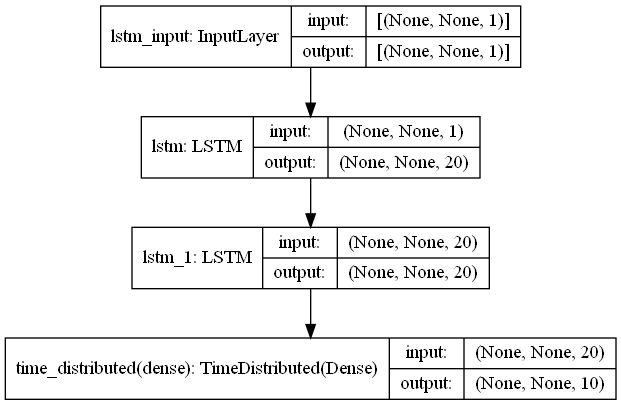

In [6]:
plot_model(model, to_file='./b5_model_LSTM_TimeD.png', show_shapes=True)

In [7]:
%%time
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 7s 131ms/step - loss: 0.1321 - last_time_step_mse: 0.1266 - val_loss: 0.1175 - val_last_time_step_mse: 0.1195
Epoch 2/20
22/22 [==============================] - 2s 73ms/step - loss: 0.1014 - last_time_step_mse: 0.0894 - val_loss: 0.0899 - val_last_time_step_mse: 0.0797
Epoch 3/20
22/22 [==============================] - 2s 74ms/step - loss: 0.0851 - last_time_step_mse: 0.0697 - val_loss: 0.0790 - val_last_time_step_mse: 0.0686
Epoch 4/20
22/22 [==============================] - 2s 73ms/step - loss: 0.0764 - last_time_step_mse: 0.0602 - val_loss: 0.0718 - val_last_time_step_mse: 0.0606
Epoch 5/20
22/22 [==============================] - 2s 73ms/step - loss: 0.0700 - last_time_step_mse: 0.0535 - val_loss: 0.0664 - val_last_time_step_mse: 0.0524
Epoch 6/20
22/22 [==============================] - 2s 73ms/step - loss: 0.0647 - last_time_step_mse: 0.0468 - val_loss: 0.0618 - val_last_time_step_mse: 0.0467
Epoch 7/20
22/22 [===============

In [8]:
model.evaluate(X_valid, Y_valid)

7/7 [==============================] - 0s 17ms/step - loss: 0.0426 - last_time_step_mse: 0.0231


[0.04264531657099724, 0.023144975304603577]

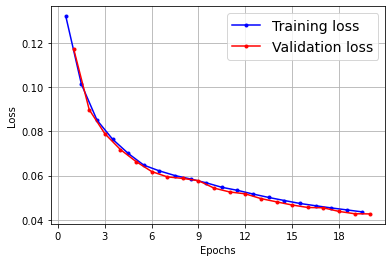

In [9]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [10]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

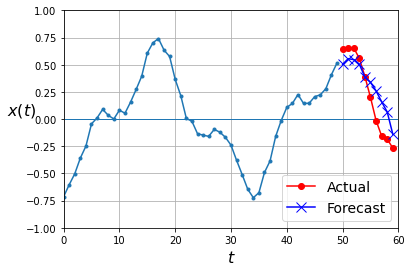

In [11]:
myplot.plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [12]:
b5 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of LSTM :', b5)

The loss of LSTM : 0.04355386644601822


# Results Summary

In [13]:
models = pd.DataFrame({
    'Model': ['LSTM+loopforward'],
    'Score': [b5 ]})
models.sort_values(by='Score', ascending=True)

Model     Score
0  LSTM+loopforward  0.043554